In [1]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif']=['FangSong']
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from pipe_fn import infix, and_then
from linq.standard.general import Map
from pattern_matching import var, when, t, Match

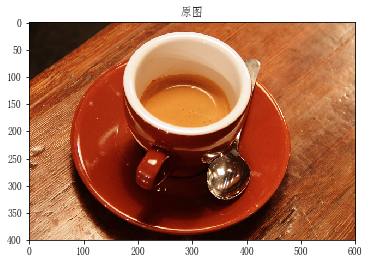

In [2]:
"""
原图， 取一个色道
"""
img = data.coffee()

"""
取255个灰度数
"""
nbins = 255

plt.imshow(img)
plt.title("原图")
plt.show()

In [3]:
"""
直方图均衡化化实现
"""

def plot_hist(_bins, _hist, label):
    return plt.bar(_bins[:-1], hist)

def hist_equalization2d(img, nbins):
        # 对 **灰度图** 或者 **彩色图** 的单个色道，
        # 进行直方图均衡化
        hist, bins = np.histogram(img, nbins)
        hist = np.hstack(([0], hist))
        # hist是像素分布直方图，bins是直方图横坐标对应的像素值向量
        return and_then(
            lambda x: x.cumsum(),  
            # 计算累计分布
            
            lambda x: x/x[-1],  
            # 根据像素出现概率做归一化
            
            lambda x: x*255,  
            # 放缩到 0-255
            
            lambda x: np.vectorize(lambda i: x[i])(img.flatten())
                        .reshape(img.shape)
                        .astype(np.uint8)
            # 按照均衡化后的像素分布，通过插值重整图像
            
        )(hist)

@when(var[t == np.ndarray]
        .when(lambda img: img.ndim in (2, 3)),
        # 只接受灰度图(矩阵)或者彩色图(三阶张量，最后一维维数为3)
      var[int])
def hist_equalization(img, nbins):

    with Match(img.shape) as match:
        for row, col in match.case((var[int],)*2):
            
            return hist_equalization2d(img, nbins).astype(np.uint8)
        
        for row, col, channel in match.case((var[int], )*3):
            if channel is 3:
                return and_then(
                        infix/np.transpose@(2, 0, 1),  
                        # 将张量的维度从 (m x n x 3) 重整为 (3 x m x n)
                        infix/Map@(
                                infix/hist_equalization2d@nbins),
                        # 对每个色道做 nbins 的直方图均衡化
                                
                        infix/np.stack@2,
                        # 在第3个维度上把三个矩阵组合成起来，变成一张彩色图。
                        
                        lambda x: x.astype(np.uint8)
                        # 转化为0-255像素
                        
                        )(img)
            else: # 单色道图片
                return hist_equalization2d(img[:, :, 0], nbins).astype(np.uint8)

        else:
            raise ValueError(
                    '输入图像格式应该为(m x n)或(m x n x 3)或(m x n x 1)的。')

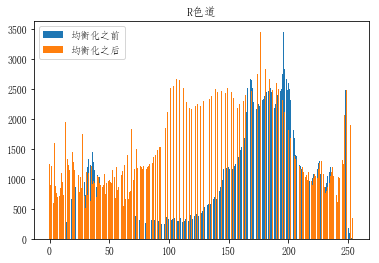

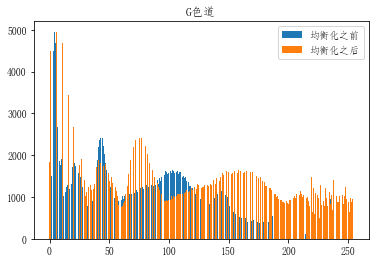

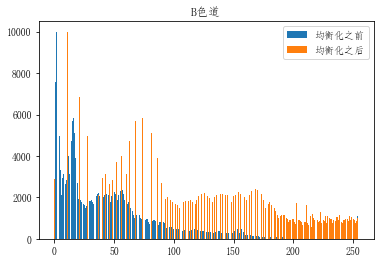

In [4]:
new_img = hist_equalization(img, nbins)

hist, bins = np.histogram(img[:, :, 0], nbins)
new_hist, new_bins = np.histogram(new_img[:, :, 0], nbins)

plt.figure()
plt.bar(bins[:-1], hist, label="均衡化之前")
plt.bar(new_bins[:-1], new_hist, label="均衡化之后")
plt.title('R色道')
plt.legend()
plt.show()

hist, bins = np.histogram(img[:, :, 1], nbins)
new_hist, new_bins = np.histogram(new_img[:, :, 1], nbins)

plt.figure()
plt.bar(bins[:-1], hist, label="均衡化之前")
plt.bar(new_bins[:-1], new_hist, label="均衡化之后")
plt.title('G色道')
plt.legend()
plt.show()

hist, bins = np.histogram(img[:, :, 2], nbins)
new_hist, new_bins = np.histogram(new_img[:, :, 2], nbins)


plt.figure()
plt.bar(bins[:-1], hist, label="均衡化之前")
plt.bar(new_bins[:-1], new_hist, label="均衡化之后")
plt.title('B色道')
plt.legend()
plt.show()

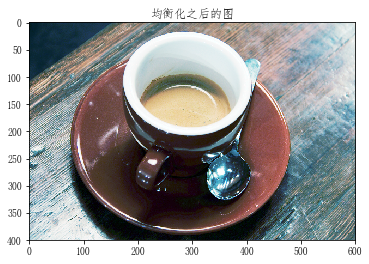

In [5]:
plt.imshow(new_img)
plt.title("均衡化之后的图")
plt.show()